# GET TO THE BOTTOM EVERYTHING!

## /r/place investigation

![img](https://artinsights.com/wp-content/uploads/2020/03/2508ZombieIsland750-scaled.jpg)

In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()

# Reddit Place Data
## 162 MILLION PIXEL POINTS!
- 162_331_820

In [2]:
df = pd.read_parquet("/media/robmulla/moardata/reddit_place2/com')

FileNotFoundError: [Errno 2] No such file or directory: '/media/robmulla/moardata/reddit_place2/combined_v1.parquet'

In [3]:
df.shape

(162331820, 5)

# Find an Example - Real Person
- They aren't exact about the time inbetween pixel placement.
- They don't post more than a few dozen times.

- Look into where the pixels are placed.

In [4]:
%%time
sample = df.loc[df['user_id'] == "PMAuNsugza6ZrCK5j6xyAjOO2XPJFMnoLRLxnfiX3rqXl9F4mcXnHHADMMlw8sfnjgjclN49rAzyJjmDYHz1Zg=="].copy()
sample = sample.sort_values('timestamp').reset_index(drop=True)
sample['diff'] = sample['timestamp'].diff()
sample['diff_secs'] = sample['diff'].dt.total_seconds()

CPU times: user 24.5 s, sys: 1.79 s, total: 26.3 s
Wall time: 26.1 s


## Idea to speed things up
1. Sort by user.
2. Chunk into user datasets

In [5]:
sample["diff_secs"]

0          NaN
1      308.058
2     3833.088
3      309.926
4      319.888
5      313.868
6      344.082
7      327.112
8      657.667
9     4090.770
10     307.991
11     645.056
12     374.400
13    4258.446
14     581.936
15     411.033
16     514.698
Name: diff_secs, dtype: float64

## Where did this user place tiles?

In [6]:
from utils import load_combine_canvas, unstack_metadata

In [16]:
meta_data = pd.read_parquet("place_metadata.parquet")
four_views = unstack_metadata(meta_data)
img = load_combine_canvas(four_views.reset_index(drop=True).loc[8000])

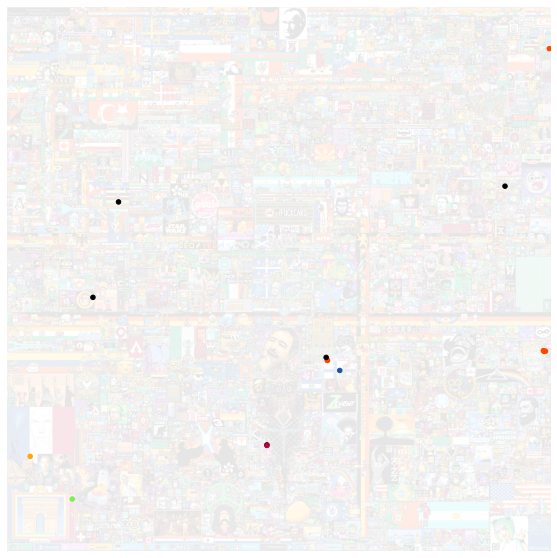

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor("white")
ax.imshow(np.ones_like(img))
ax.imshow(img, alpha=0.10)
ax.axis("off")
sample.plot(kind="scatter", x="x", y="y", color=sample["pixel_color"], ax=ax)
plt.show()

# Try to find a bot
## 10 Million Users
- 10_381_163 Users
An average user placed 16.2 tiles during the event.

In [31]:
user_counts = df["user_id"].value_counts()
user_counts = user_counts.reset_index()
user_counts.columns = ["user_id", "pixel_count"]

In [32]:
user_counts.shape

(10381163, 2)

In [ ]:
user_counts['pixel_count'].plot(kind='kde', figsize=(15, 5))

In [34]:
user_counts_ = user_counts.sample(10_000, random_state=529).copy()
user_counts_ = user_counts_.reset_index(drop=True).copy()

In [40]:
plt.style.use("ggplot")

<AxesSubplot:ylabel='Frequency'>

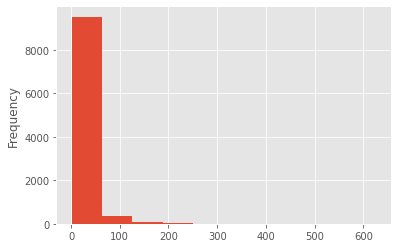

In [41]:
user_counts_["pixel_count"].plot(kind="hist")

In [42]:
start_time = df["timestamp"].min()
end_time = df["timestamp"].max()

In [45]:
end_time - start_time

Timedelta('3 days 11:29:49.892000')

In [46]:
event_minutes = (60 * 24 * 3) + (11 * 60) + (30)

In [48]:
event_minutes / 5

1002.0

## Max Possible Placement
- 1002 pixel could be placed if done every chance.

In [52]:
# 800+ pixel placed user
max_user = user_counts["user_id"].values[0]

In [54]:
%%time
max_user_df = df.loc[df['user_id'] == max_user].copy()
max_user_df = max_user_df.sort_values("timestamp").reset_index(drop=True)

CPU times: user 25.8 s, sys: 869 ms, total: 26.7 s
Wall time: 26.5 s


In [63]:
def add_diffs(df):
    df = df.sort_values("timestamp").reset_index(drop=True)
    df["diff"] = df["timestamp"].diff()
    df["diff_secs"] = df["diff"].dt.total_seconds()
    return df

In [66]:
max_user_df = add_diffs(max_user_df)

<AxesSubplot:ylabel='Frequency'>

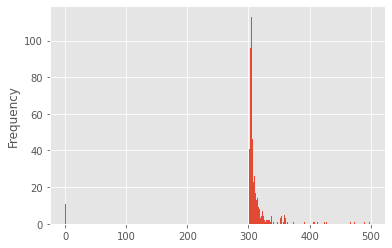

In [71]:
max_user_df.query("diff_secs < 500")["diff_secs"].plot(kind="hist", bins=500)

Text(2022-04-04 18:14:00.207000+00:00, 17500, 'Event End')

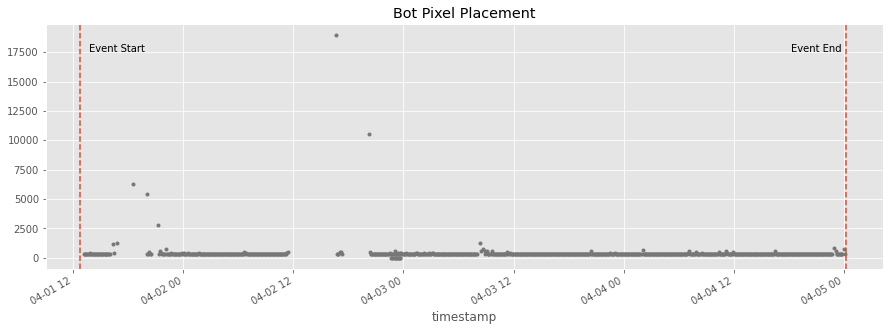

In [102]:
ax = max_user_df.set_index("timestamp")["diff_secs"].plot(
    style=".", color=color_pal[3], figsize=(15, 5), title="Bot Pixel Placement"
)
ax.axvline(start_time, ls="--")
ax.text(x=start_time + pd.Timedelta("1 hour"), y=17500, s="Event Start")

ax.axvline(end_time, ls="--")
ax.text(x=end_time - pd.Timedelta("6 hour"), y=17500, s="Event End")

# Can we find a box created mid-event?

In [ ]:
%%time
mid_user = user_counts.query("pixel_count == 150")["user_id"].values[0]
mid_user_df = df.loc[df['user_id'] == mid_user].copy()
mid_user_df = mid_user_df.sort_values("timestamp").reset_index(drop=True)
mid_user_df = add_diffs(mid_user_df)

CPU times: user 24.5 s, sys: 543 ms, total: 25 s
Wall time: 24.9 s


In [135]:
def plot_user(df):
    ax = df.set_index("timestamp")["diff_secs"].plot(
        style=".", color=color_pal[3], figsize=(15, 5), title="Bot Pixel Placement"
    )
    ax.axvline(start_time, ls="--")
    ax.text(
        x=start_time + pd.Timedelta("1 hour"),
        y=df["diff_secs"].max() - 100,
        s="Event Start",
    )

    ax.axvline(end_time, ls="--")
    ax.text(
        x=end_time - pd.Timedelta("6 hour"),
        y=df["diff_secs"].max() - 100,
        s="Event End",
    )
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Seconds since last pixel placed")
    plt.show()

In [126]:
pd.to_datetime("04-04-2022 00:00")

Timestamp('2022-04-04 00:00:00')

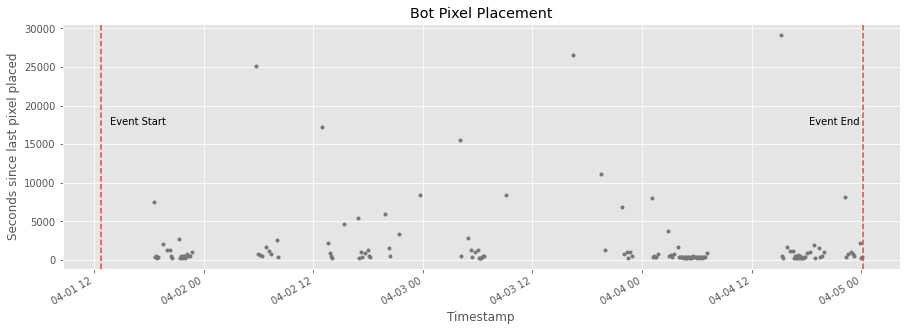

In [131]:
plot_user(mid_user_df)

## Plot This User's Placement

In [194]:
def plot_user_pixels(df, alpha=0.1, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("white")
    ax.imshow(np.ones_like(img))
    ax.imshow(img, alpha=alpha)
    ax.axis("off")
    df.plot(kind="scatter", x="x", y="y", color=df["pixel_color"], ax=ax)
    return ax

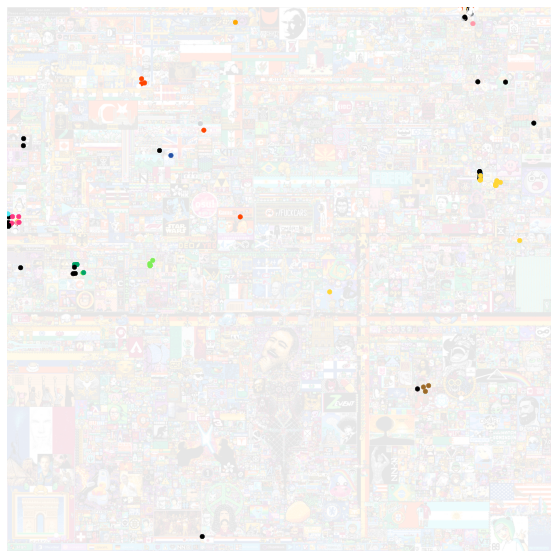

In [120]:
plot_user_pixels(mid_user_df)

# Zoom on on when they were placing consistently

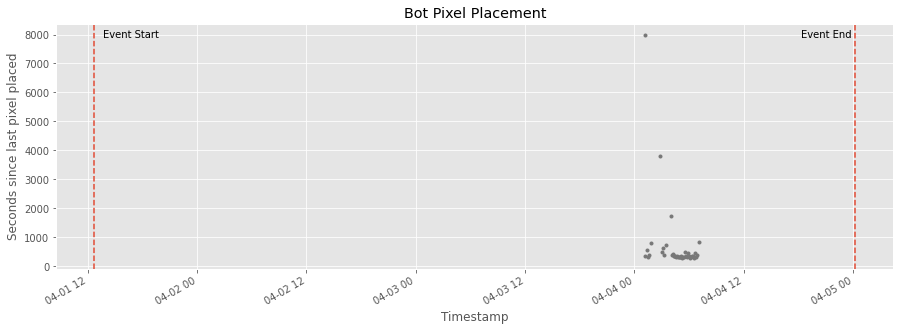

In [136]:
mid_user_df_ = mid_user_df.loc[
    (mid_user_df["timestamp"] > pd.to_datetime("04-04-2022 00:00").tz_localize("utc"))
    & (mid_user_df["timestamp"] < pd.to_datetime("04-04-2022 12:00").tz_localize("utc"))
]
plot_user(mid_user_df_)

In [152]:
mid_user_df_["y"].mean()

60.45238095238095

(30.0, 0.0)

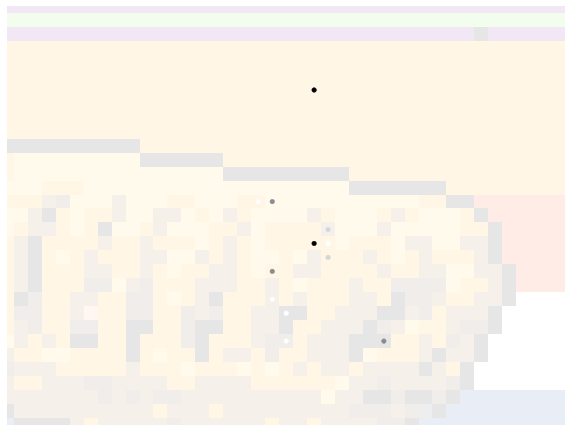

In [167]:
ax = plot_user_pixels(mid_user_df_.query("x > 1000"))
ax.set_xlim(1680, 1720)
ax.set_ylim(30, 0)

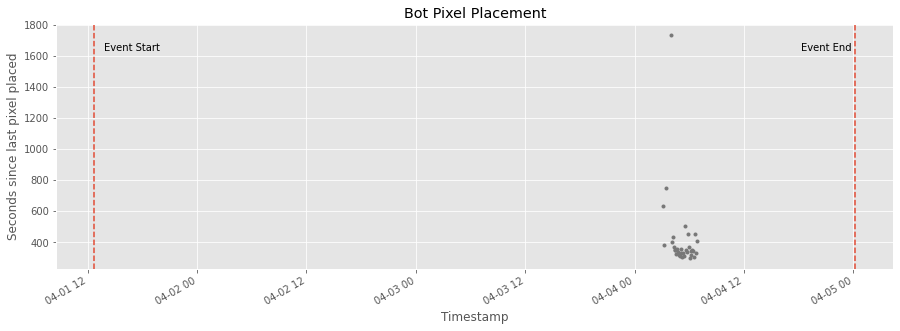

In [172]:
mid_user_df_ = mid_user_df.loc[
    (mid_user_df["timestamp"] > pd.to_datetime("04-04-2022 03:00").tz_localize("utc"))
    & (mid_user_df["timestamp"] < pd.to_datetime("04-04-2022 07:00").tz_localize("utc"))
    & (mid_user_df["y"] < 30)
    & (mid_user_df["x"] >= 1680)
    & (mid_user_df["x"] <= 1720)
]
plot_user(mid_user_df_)

## Find out what was being placed at this time

In [173]:
%%time
df_battle = df.loc[
    (df["timestamp"] > pd.to_datetime("04-04-2022 03:00").tz_localize("utc"))
    & (df["timestamp"] < pd.to_datetime("04-04-2022 07:00").tz_localize("utc"))
    & (df["y"] < 30)
    & (df["x"] >= 1680)
    & (df["x"] <= 1720)
]

CPU times: user 1.2 s, sys: 695 ms, total: 1.9 s
Wall time: 1.9 s


(30.0, 0.0)

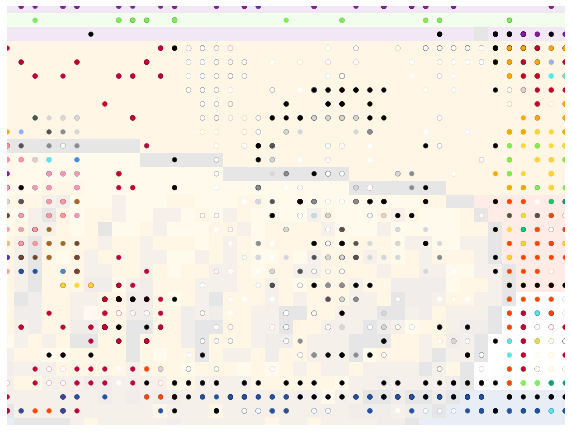

In [175]:
ax = plot_user_pixels(df_battle)
ax.set_xlim(1680, 1720)
ax.set_ylim(30, 0)

In [176]:
import plotly.express as px

In [181]:
mid_user_df_.head()

timestamp  \
81 2022-04-04 03:09:49.311000+00:00   
82 2022-04-04 03:16:10.685000+00:00   
83 2022-04-04 03:28:40.178000+00:00   
84 2022-04-04 03:57:31.973000+00:00   
85 2022-04-04 04:04:15.377000+00:00   

                                              user_id pixel_color     x   y  \
81  XgcHJuwIx6eCYawqhE/UdAi3j8vbVsrSh03OKed0Oxpt73...     #000000  1702  17   
82  XgcHJuwIx6eCYawqhE/UdAi3j8vbVsrSh03OKed0Oxpt73...     #D4D7D9  1703  18   
83  XgcHJuwIx6eCYawqhE/UdAi3j8vbVsrSh03OKed0Oxpt73...     #FFFFFF  1703  17   
84  XgcHJuwIx6eCYawqhE/UdAi3j8vbVsrSh03OKed0Oxpt73...     #FFFFFF  1703  17   
85  XgcHJuwIx6eCYawqhE/UdAi3j8vbVsrSh03OKed0Oxpt73...     #000000  1702   6   

                     diff  diff_secs  
81 0 days 00:10:34.440000    634.440  
82 0 days 00:06:21.374000    381.374  
83 0 days 00:12:29.493000    749.493  
84 0 days 00:28:51.795000   1731.795  
85 0 days 00:06:43.404000    403.404

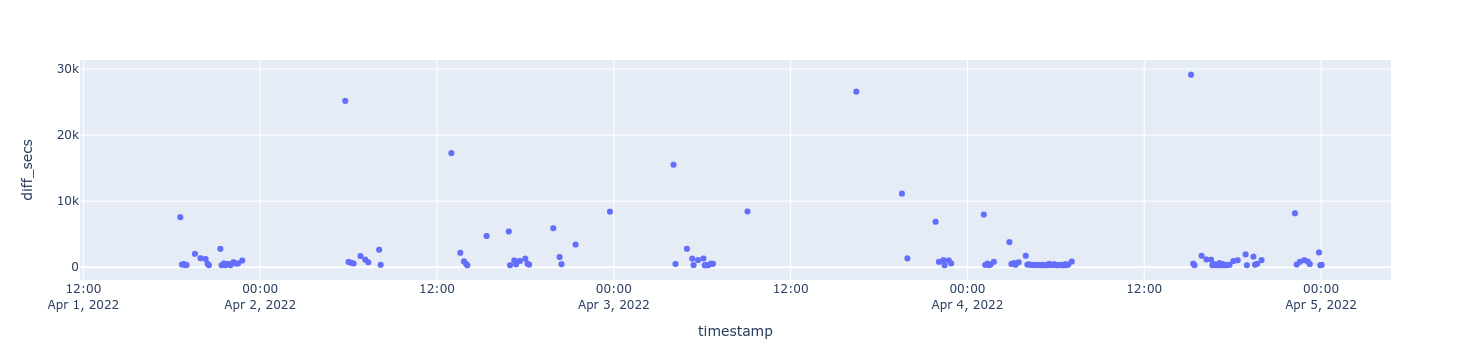

In [186]:
px.scatter(mid_user_df, x="timestamp", y="diff_secs")

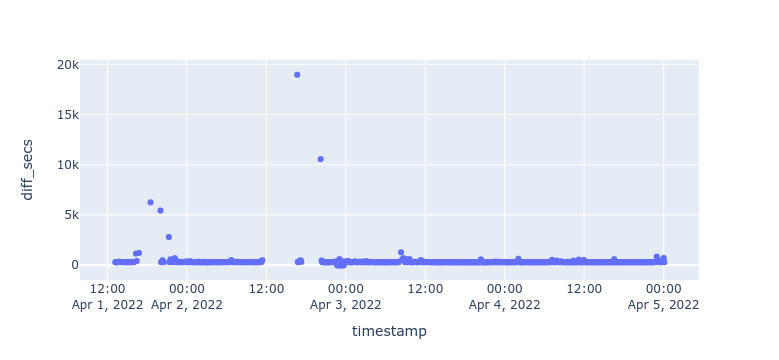

In [187]:
px.scatter(max_user_df, x="timestamp", y="diff_secs")

# Compare to a different high pixel placement user.

In [188]:
%%time
other_user = user_counts.query("pixel_count == 300")["user_id"].values[0]
other_user_df = df.loc[df['user_id'] == other_user].copy()
other_user_df = other_user_df.sort_values("timestamp").reset_index(drop=True)
other_user_df = add_diffs(other_user_df)

CPU times: user 24.8 s, sys: 778 ms, total: 25.6 s
Wall time: 25.6 s


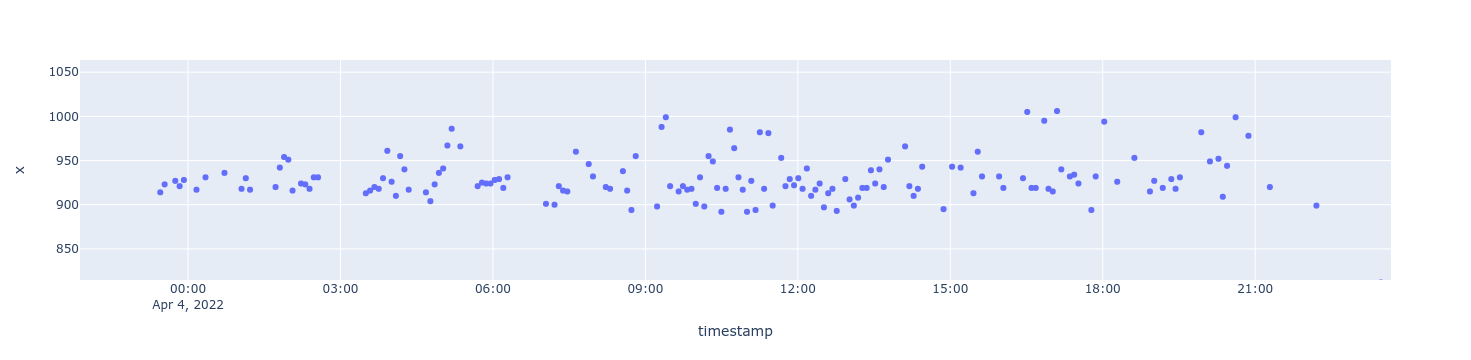

In [191]:
px.scatter(other_user_df, x="timestamp", y="x")

<AxesSubplot:xlabel='x', ylabel='y'>

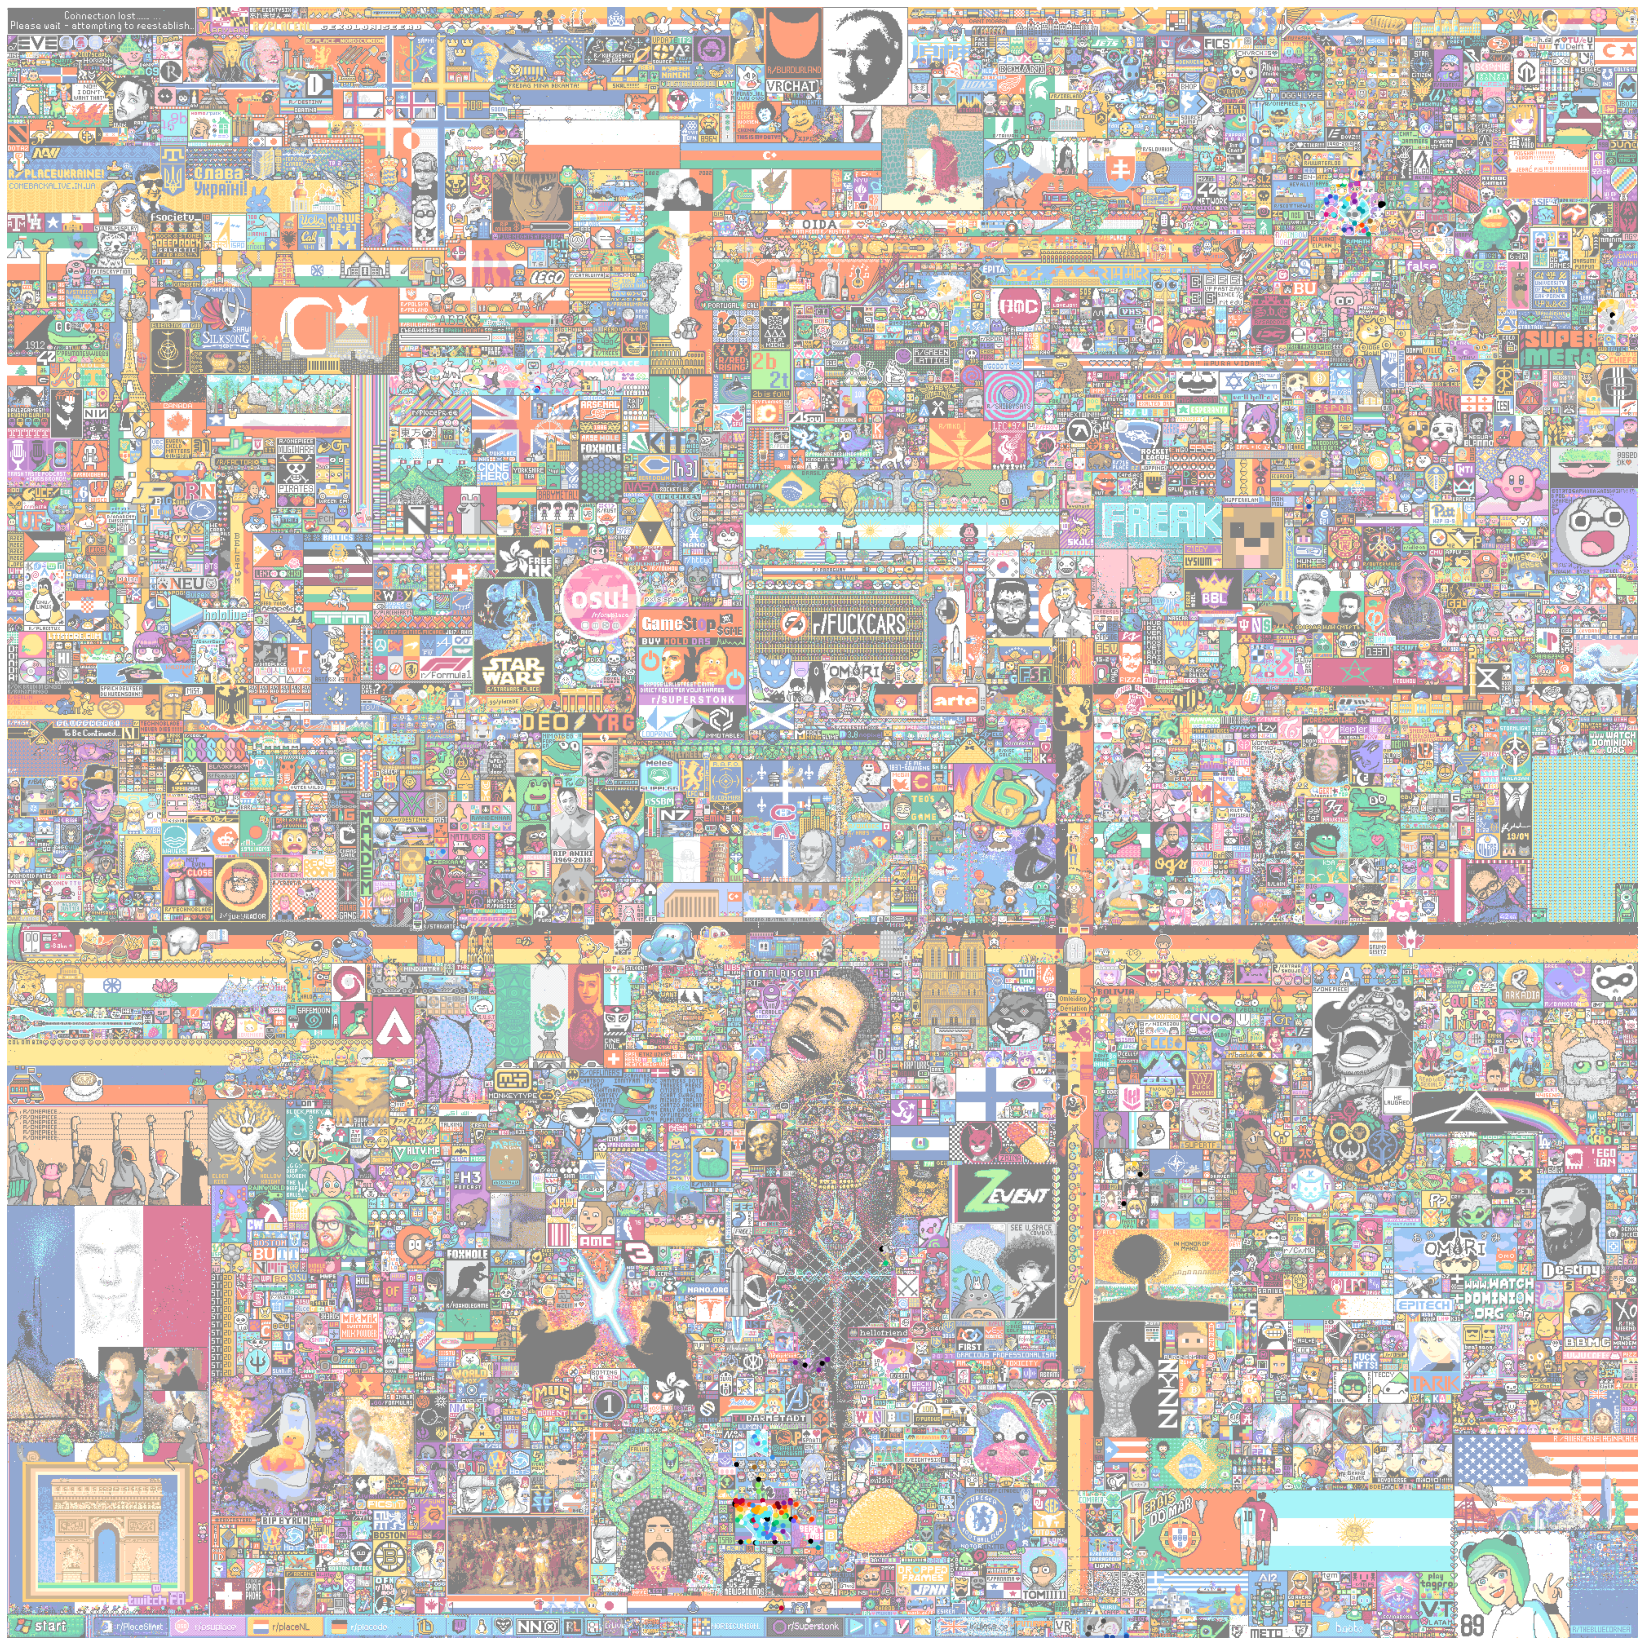

In [195]:
plot_user_pixels(other_user_df, alpha=0.5, figsize=(30, 30))

# Find Each user's average diff time

In [198]:
user_array = df["user_id"].unique()

In [201]:
%%time
subset = df.loc[df['user_id'].isin(user_array[:100])].reset_index(drop=True).copy()

CPU times: user 16.7 s, sys: 311 ms, total: 17 s
Wall time: 16.9 s


In [255]:
subset = subset.drop_duplicates(
    subset=["timestamp", "user_id", "pixel_color", "x", "y"]
).reset_index(drop=True)

In [256]:
subset["diff"] = (
    subset.sort_values("timestamp")
    .groupby("user_id")["timestamp"]
    .diff()
    .dt.total_seconds()
)

<AxesSubplot:ylabel='Frequency'>

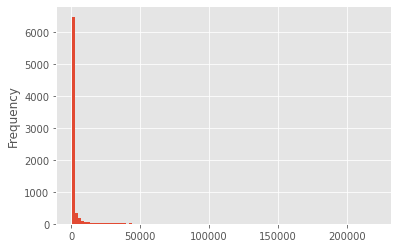

In [257]:
subset["diff"].plot(kind="hist", bins=100)

In [258]:
user_aggs = (
    subset.groupby("user_id")["diff"]
    .agg(["min", "max", "std", "median", "count"])
    .reset_index()
)

<AxesSubplot:ylabel='Frequency'>

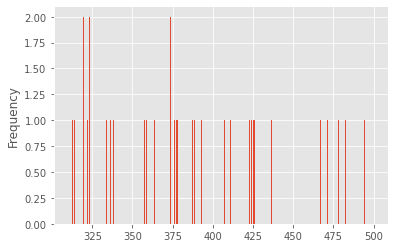

In [270]:
user_aggs.query("median < 500")["median"].plot(kind="hist", bins=500)

In [276]:
sus_user = user_aggs.loc[94]["user_id"]

In [284]:
user_aggs.query("median < 350 and count > 50").sort_values("median")

user_id      min         max  \
5   3gX+nYoGzMIZdDAop7u5P8nWv5K85zkGVTYXmI9IsF+4Q/...  301.372   56993.779   
40  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...  300.016   30961.970   
4   2lnx9Gh+RzWPq5IwN9qd1P+/aRrnEM2vmmA/C0JPzlVXp8...  300.875   83539.998   
38  NzpZ2/8zE9ugQ0WWHcR8JvoIWI66Xq9fOforNn2GPEcFCW...  303.114    4590.403   
95  w858hlVPwaWV9xrQ13FHogs4R1COQru1MWaztX5NHuju1N...  303.135   99052.867   
94  vEJ1GOb2b94pbQAnon+aYWYbFsC/OwWj6tK697j/PCJZ3f...  301.342   26981.489   
16  DjkxqxC/erxJeoxg1TKR2MnHTWTyMY2IgLVJE50IZecmK1...  301.513   94433.251   
71  g1JMbbsUXYMGu+rRiRjfBswwN06U8OSqqQD9UB22vJPCyL...  302.142  174432.121   
64  ebR93Vtn4WtdCbdPYeDtXymqymF3SU8jOhctg/1i1ihbqQ...  302.403   69255.490   

             std    median  count  
5   10593.266270  310.3840     66  
40   2367.611138  311.5360    408  
4   13194.980575  312.7450     85  
38    705.389404  319.7130     65  
95  14324.639318  319.8095     52  
94   3201.430616  323.6220    259  
16  13915.801900  325.2240     61  
71  22990.144396  333.7965     58  
64   7804.473516  338.3410    147

In [289]:
sus_users = user_aggs.query("median < 350 and count > 50")["user_id"].unique()

In [294]:
user_aggs

user_id      min        max  \
0   +Ow5q6Mnlg3B+OFvz+Nr+0dHO4iz3+xaWRSPZqJBu6UCgF...  300.130  67269.509   
1   +voGbaa2YXvJ5Pp0ps2JQpLxG34faCYEzbFnnNVDFpFm1G...  667.352  63048.844   
2   09JOtTolN/iODbsnAfON2QroU8Q39mUMHVwdbWNCnx56wS...  301.298  39364.366   
3   0PiT+Zl57hDF6kyg2JmN33a5aiiBfe0LKBXVanTO9wPziq...  303.511  35370.080   
4   2lnx9Gh+RzWPq5IwN9qd1P+/aRrnEM2vmmA/C0JPzlVXp8...  300.875  83539.998   
..                                                ...      ...        ...   
95  w858hlVPwaWV9xrQ13FHogs4R1COQru1MWaztX5NHuju1N...  303.135  99052.867   
96  xwBFlc8hRBG2Hwp4VlVJFlLrVZ8jog+dMtPR+QSWmgffYR...  301.741  24865.183   
97  y8+/uszM2hr1DUNmLqqIRGUBDw86plp9fcnOg5CFsSnUsl...  301.804  76436.515   
98  yn9PoMFBhZCMkC4I2ZJ9zPmTTf4FIS/ICzS8eP3SDO6uBs...  342.204  94323.002   
99  zJZhO+l5p4re6gf0gzFXhC67O8EzOLLSWlbF7hBG4KsqgV...  301.372  20873.627   

             std     median  count  
0    9940.756842   424.0640     65  
1   15878.182788  2324.2210     31  
2    4087.879256   377.3500    197  
3    5506.599051   755.8470    108  
4   13194.980575   312.7450     85  
..           ...        ...    ...  
95  14324.639318   319.8095     52  
96   4324.151305   478.1840     32  
97  11309.440266   385.0785     68  
98  22155.494509   714.3455     20  
99   1889.335224   350.4540    381  

[100 rows x 6 columns]

In [290]:
sus = subset.query("user_id in @sus_users")

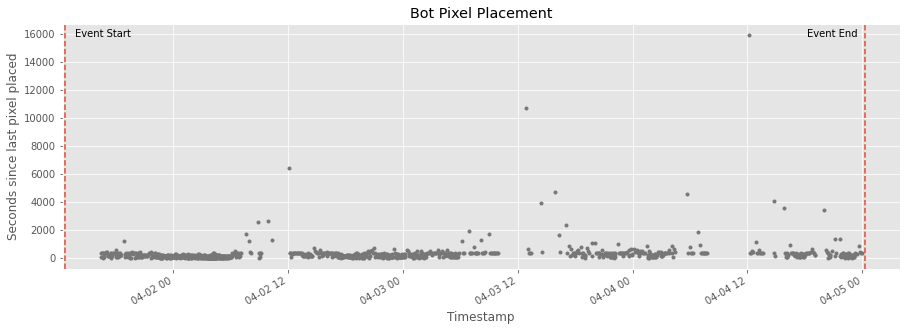

In [292]:
sus = add_diffs(sus)
plot_user(sus)

<AxesSubplot:xlabel='x', ylabel='y'>

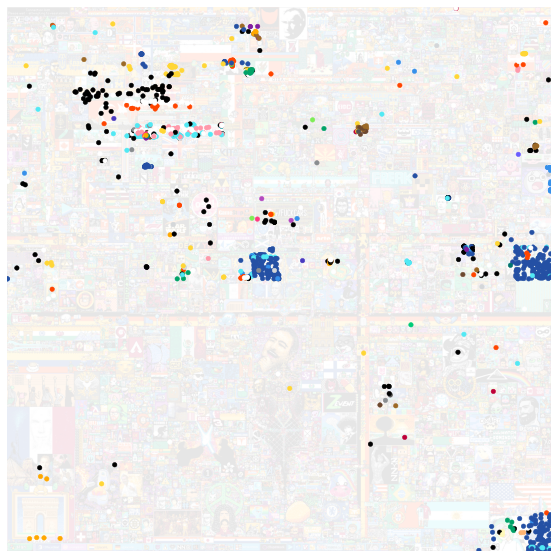

In [293]:
plot_user_pixels(sus)

# Look at how long the pixel existed before user placed?

In [297]:
sus_user = "P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oFSiLdLu5OHzyaTKNp00DdaNQ5ZJIoUTV/RT7LS7TQ=="

In [300]:
subset.query("user_id == @sus_user").head(10)

timestamp  \
52  2022-04-02 04:09:52.680000+00:00   
101 2022-04-02 04:14:57.321000+00:00   
161 2022-04-02 04:19:59.078000+00:00   
204 2022-04-02 04:25:00.247000+00:00   
238 2022-04-02 04:30:01.736000+00:00   
272 2022-04-02 04:35:02.421000+00:00   
305 2022-04-02 04:40:04.184000+00:00   
332 2022-04-02 04:45:05.765000+00:00   
362 2022-04-02 04:50:11.764000+00:00   
386 2022-04-02 04:55:12.683000+00:00   

                                               user_id pixel_color    x    y  \
52   P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  912  928   
101  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  914  926   
161  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  922  926   
204  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  915  925   
238  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  992  924   
272  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  911  987   
305  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #51E9F4  906  921   
332  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  987  924   
362  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  904  932   
386  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  939  998   

        diff  
52   383.562  
101  304.641  
161  301.757  
204  301.169  
238  301.489  
272  300.685  
305  301.763  
332  301.581  
362  305.999  
386  300.919

In [318]:
sus_pixel = df.query("x == 992 and y == 924")

In [319]:
sus_pixel = sus_pixel.sort_values("timestamp").reset_index(drop=True).copy()

In [320]:
sus_pixel.head()

timestamp  \
0 2022-04-01 14:06:42.483000+00:00   
1 2022-04-01 16:42:50.863000+00:00   
2 2022-04-01 16:42:57.323000+00:00   
3 2022-04-01 16:44:06.322000+00:00   
4 2022-04-01 17:45:23.295000+00:00   

                                             user_id pixel_color    x    y  
0  owColRDe4aTAfo95F+zvAYd53nP1L63JvewRFacySh1c6q...     #2450A4  992  924  
1  NZcYLlmiFcRnChB11tsjIkjcAMBmv0ox/3auvs2/jqOX5w...     #3690EA  992  924  
2  fjhKuiyNRtWsiEFYyrUmEig0/IMRWuSkUf0ftTPLvXCMxw...     #2450A4  992  924  
3  4HQ2wrwD8F88AL47N8yNQoXZXrQ1lecpEH2Wx9dSbnbbKQ...     #3690EA  992  924  
4  PgQcFL8J6a4XjB13+FPFWtiyN2AMvjh0l8ExJOGatWTXrC...     #2450A4  992  924

In [321]:
sus_pixel["diff_secs"] = sus_pixel["timestamp"].diff().dt.total_seconds()

In [322]:
sus_pixel.query("user_id == @sus_user")

timestamp  \
23 2022-04-02 04:30:01.736000+00:00   

                                              user_id pixel_color    x    y  \
23  P9rJLVTxEfrVS5cph0co1k1fLaHoIYuXUoeSlP1/VHE/oF...     #2450A4  992  924   

    diff_secs  
23     21.269